In [1]:
# Importing nescessary libraries

seed =1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split as train_test_split_sur

from scipy.sparse.linalg import svds

In [2]:
data = pd.read_csv("ratings_Electronics.csv")
cols = ["userId", "productId", "ratings","time_stamp"]
data.columns = cols

In [3]:
data.head()

# There are just 4 columns, out of which time stamp is redundant in our case

,userId,productId,ratings,time_stamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
print("The number of rows in the dataset is", data.shape[0])
print("The number of columns in the dataset is", data.shape[1])

The number of rows in the dataset is 7824481
The number of columns in the dataset is 4


In [5]:
data.dtypes

# The userId and productId are of object data type.
# Ratings is a float64 data type
# time stamp is int64 data type

userId         object
productId      object
ratings       float64
time_stamp      int64
dtype: object

In [6]:
data.describe().T

# From the below table it can be inferred that, the mean rating is around 4, the minimum rating is 1, and the max rating is 5

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
time_stamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [7]:
data['ratings'].value_counts()

# Ratings range from 1 to 5. With 1 being the lowest rating and 5 being the Max rating.
# It can be seen that, maximum products have been rated 5. 
# Very less products have been rated 2 or below. (compared to other rated products)

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

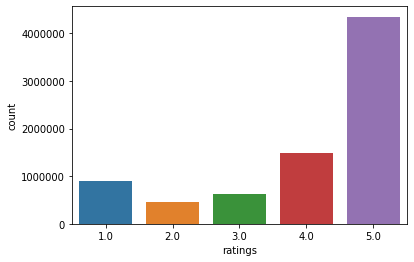

In [8]:
sns.countplot(data['ratings'])

# From the blow graph, it is evident that a large amount of products have been rated as 5.

# Well, this might cause some bias in our final model. 

# There should also be many individual products which have got only one rating of '5'.
# We should be mindful of those as well.

# Let us see how that turns out, down the lane.


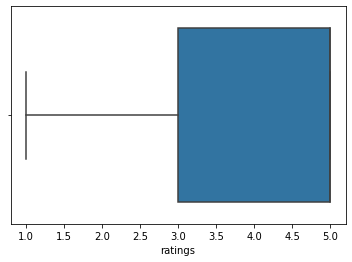

In [9]:
sns.boxplot(data['ratings'])
plt.show()

# Since this is just a ratings data, there are obviously no outliers.

In [10]:
data['userId'].value_counts()

# It is clear that there are 4201696 unique users in the dataset

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1P2BKYKSBWGHN      1
AUBJSWMAAANHC       1
A2WU9WUT2V5NEE      1
A39G49SW77CJ7Y      1
A3JKXHGEF7T6SS      1
Name: userId, Length: 4201696, dtype: int64

In [11]:
data['productId'].value_counts()

# It is clear that there are 476001 unique products in the dataset

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B000KL56DU        1
B0080DQ1FW        1
B004GUN5FW        1
B0006HXHES        1
B00182Z2MK        1
Name: productId, Length: 476001, dtype: int64

In [12]:
data.drop_duplicates(inplace=True)
# Dropping duplicates

In [13]:
data.shape
# no duplicate entries

(7824481, 4)

# Since the dataset is very dense. It has many entries which has only 'one' rating given by the user. Therefore, let us only consider 'users' who gave given "50 or more ratings" and  'products' which has received "20 or more ratings"

In [14]:
count = data['userId'].value_counts()
count[count >= 50]

# As opposed to the initial 4201696 unique users, There are only 1540 users who have given 50 or more ratings

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A3JAH5WW61N2EK     50
A95PWI4S6WHGL      50
A1W4F91DH3XPB2     50
A3BY5KCNQZXV5U     50
A2QIC4G483SQQA     50
Name: userId, Length: 1540, dtype: int64

In [15]:
data_1 = data[data['userId'].isin(count[count >= 50].index)]

# considering only the user who gave 50 or more ratings

In [16]:
count_prod = data_1['productId'].value_counts()
count_prod[count_prod>=20]

# It is not a good idea to have products which has only 'ONE' rating. For eg, a product which has only one rating of '5'

# Therefore, i am considering only products, which have only got 20 or more reviews so we can give a reliable recommendation.

# There are only 604 such products

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B0012Y2LLE     20
B001L6LG5K     20
B002TMRZOQ     20
B0017TFVUW     20
B002RCNX8K     20
Name: productId, Length: 604, dtype: int64

In [17]:
print('The number of unique users who gave 50 more more ratings is:', len(count[count >= 50]))
print('')
print('The number of unique products which got 20 or more ratings is:', len(count_prod[count_prod>=20]))

The number of unique users who gave 50 more more ratings is: 1540

The number of unique products which got 20 or more ratings is: 604


In [22]:
data_fin = data_1[data_1['productId'].isin(count_prod[count_prod>=20].index)]

# extracting the final dataset

In [23]:
data_fin
# The final subset has only 21168 rows

,userId,productId,ratings,time_stamp
40053,A3EZEP0FX5BC1P,B00004SB92,5.0,1338422400
40075,ATDE9JYCPI0L1,B00004SB92,5.0,1235692800
40177,A14JBDSWKPKTZA,B00004SB92,5.0,1078963200
40250,A2X8KN82L07RSK,B00004SB92,4.0,1018915200
40260,ALUNVOQRXOZIA,B00004SB92,1.0,965347200
...,...,...,...,...
7820339,AIJQU979J6UFY,B00K91DB7Y,4.0,1403913600
7820345,ALDAF4VVLFRHP,B00K91DB7Y,4.0,1404086400
7820355,A1BT6TL7UCIC5Y,B00K91DB7Y,5.0,1405814400
7820366,A3M7BCQKSQAK4L,B00K91DB7Y,5.0,1403481600


In [24]:
data_fin = data_fin.drop(['time_stamp'], axis=1)
# Removing the redundant "time_stamp" column

data_fin.head()

,userId,productId,ratings
40053,A3EZEP0FX5BC1P,B00004SB92,5.0
40075,ATDE9JYCPI0L1,B00004SB92,5.0
40177,A14JBDSWKPKTZA,B00004SB92,5.0
40250,A2X8KN82L07RSK,B00004SB92,4.0
40260,ALUNVOQRXOZIA,B00004SB92,1.0


# POPULARITY BASED RECOMMENDOR SYSTEM

In [25]:
ratings_mean = data_fin.groupby('productId').mean()
fin_rating = ratings_mean.sort_values('ratings',ascending=False)

# grouping by product id to get the mean ratings for each product

In [26]:
data_fin.groupby('productId')['ratings'].count()
# grouping the product id to find the "ratings" count

productId
B00004SB92    21
B00004ZCJE    72
B00005LEN4    31
B00005T3G0    31
B000067RT6    41
              ..
B00JC5Y6WM    37
B00JC5Y6YA    24
B00JF0D7RE    30
B00JP12170    50
B00K91DB7Y    26
Name: ratings, Length: 604, dtype: int64

In [27]:
fin_rating['no_of_rating'] =  data_fin.groupby('productId')['ratings'].count()

In [34]:
fin_rating

,ratings,no_of_rating
productId,,
B0052SCU8U,4.979592,49
B0046TJG1U,4.958333,24
B00BW6KCTU,4.952381,21
B000F7QRTG,4.950000,20
B003ES5ZR8,4.933333,30
...,...,...
B0035JJJQY,3.192308,26
B000W6POQW,3.095238,21
B004QK8FBG,3.000000,31


In [36]:
def recommend(user_id):     
    user_recommendations = fin_rating.copy()
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['For userId'] = user_id 
      
    
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    
    user_recommendations = user_recommendations[cols] 
    print("The top 10 reccommended prodcuts are: ")
    return user_recommendations.head(10)

# creating a function to list out the "Top 10 recommended products"

In [37]:
recommend('A14JBDSWKPKTZA')

The top 10 reccommended prodcuts are: 


,For userId,ratings,no_of_rating
productId,,,
B0052SCU8U,A14JBDSWKPKTZA,4.979592,49
B0046TJG1U,A14JBDSWKPKTZA,4.958333,24
B00BW6KCTU,A14JBDSWKPKTZA,4.952381,21
B000F7QRTG,A14JBDSWKPKTZA,4.950000,20
B003ES5ZR8,A14JBDSWKPKTZA,4.933333,30
B001TH7T2U,A14JBDSWKPKTZA,4.925000,40
B005ES0YYA,A14JBDSWKPKTZA,4.923077,26
B003FVJYF8,A14JBDSWKPKTZA,4.920000,25
B00BQ4F9ZA,A14JBDSWKPKTZA,4.911111,45


In [41]:
data = data_fin.copy()
data.reset_index(drop=True,inplace=True)

In [42]:
data

,userId,productId,ratings
0,A3EZEP0FX5BC1P,B00004SB92,5.0
1,ATDE9JYCPI0L1,B00004SB92,5.0
2,A14JBDSWKPKTZA,B00004SB92,5.0
3,A2X8KN82L07RSK,B00004SB92,4.0
4,ALUNVOQRXOZIA,B00004SB92,1.0
...,...,...,...
21163,AIJQU979J6UFY,B00K91DB7Y,4.0
21164,ALDAF4VVLFRHP,B00K91DB7Y,4.0
21165,A1BT6TL7UCIC5Y,B00K91DB7Y,5.0
21166,A3M7BCQKSQAK4L,B00K91DB7Y,5.0


# MATRIX FACTORIZATION METHOD - SVD

In [71]:
pivot_df = data.pivot(index = 'userId', columns ='productId', values = 'ratings')
pivot_df.fillna(0,inplace=True)
pivot_df.head()

productId,B00004SB92,B00004ZCJE,B00005LEN4,B00005T3G0,B000067RT6,B00006B7DA,B00006I53S,B00006JN3G,B00006RVPW,B00007E7JU,...,B00I3YKEKG,B00IL7B2YM,B00IORDBPC,B00IVFDZBC,B00IX2VGFA,B00JC5Y6WM,B00JC5Y6YA,B00JF0D7RE,B00JP12170,B00K91DB7Y
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
pivot_list = list(pivot_df.index)
pivot_df.shape

(1512, 604)

In [85]:
U, sigma, Vt = svds(pivot_df, k = 10)
sigma = np.diag(sigma)
sigma

array([[ 55.50545457,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  55.85280397,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  56.67098987,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  59.34096503,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         62.36875651,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  64.32945753,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [86]:
dot_product = np.dot(np.dot(U, sigma), Vt) 


preds_df = pd.DataFrame(dot_product, columns = pivot_df.columns)
preds_df['pivot_list'] = pivot_list

preds_df.set_index('pivot_list',inplace=True)
preds_df.head()

productId,B00004SB92,B00004ZCJE,B00005LEN4,B00005T3G0,B000067RT6,B00006B7DA,B00006I53S,B00006JN3G,B00006RVPW,B00007E7JU,...,B00I3YKEKG,B00IL7B2YM,B00IORDBPC,B00IVFDZBC,B00IX2VGFA,B00JC5Y6WM,B00JC5Y6YA,B00JF0D7RE,B00JP12170,B00K91DB7Y
pivot_list,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,-0.021121,0.278957,0.047912,0.298990,0.207535,0.145292,0.164596,0.087813,0.155150,0.080569,...,0.028195,0.337695,0.224520,-0.100307,0.654251,-0.014773,0.048030,0.882863,-0.014733,0.052995
A100WO06OQR8BQ,0.135363,-0.026383,0.324340,0.018883,0.236979,-0.091088,-0.046127,0.227519,0.107143,0.053549,...,0.088604,0.193950,0.047840,0.231856,0.295542,0.263105,0.153518,0.056849,0.382602,0.181784
A105S56ODHGJEK,0.134955,0.111956,-0.103368,-0.120803,-0.091801,0.081058,0.062380,0.040886,0.068640,0.206024,...,0.310334,0.079430,0.219546,0.325909,0.097252,0.147514,0.291765,0.145560,0.585379,0.114183
A105TOJ6LTVMBG,0.040059,0.259609,0.063963,0.158551,0.192456,0.087948,0.077622,0.100506,0.137019,0.195022,...,0.015985,-0.011060,0.022236,-0.058499,0.002702,-0.029748,-0.034573,-0.026593,0.018265,0.020813
A10AFVU66A79Y1,0.057916,0.269201,0.165331,0.067491,-0.037934,0.073410,0.048598,0.030369,-0.040315,0.123050,...,0.069683,0.106958,0.018793,0.101760,-0.001291,0.162855,0.061167,-0.093593,0.244449,0.177103


In [87]:
col = ['actual sparse','predicted sparse']
z = pd.concat([pivot_df.mean(),preds_df.mean()],axis=1)
z.columns = col
z

# mean sparse data for actual and predicted

,actual sparse,predicted sparse
productId,,
B00004SB92,0.060847,0.046078
B00004ZCJE,0.202381,0.189535
B00005LEN4,0.096561,0.071166
B00005T3G0,0.096561,0.100256
B000067RT6,0.130291,0.127050
...,...,...
B00JC5Y6WM,0.114418,0.107035
B00JC5Y6YA,0.064153,0.048782
B00JF0D7RE,0.091931,0.088643


In [88]:
RMSE = round(((z['actual sparse'] - z['predicted sparse'])**2).mean()**0.5,4)
print("The RMSE is:",RMSE)

# This is a low RMSE level

The RMSE is: 0.013


# A function to recommend users Top 5 (k-5) new products, which they have not tried. 

In [142]:
def recommend_items(userID):
      
    user_idx = userID
    
    sorted_user_ratings = pivot_df.loc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_idx].sort_values(ascending=False)
    

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the Top 5 recommended items for user_id = {}\n'.format(userID))
    print(temp.head(5))

In [143]:
recommend_items('A2NSMJVQY0RV9S')

# Recommendation for user - A100WO06OQR8BQ
# The below recommendation contains products reccomendations for users,based on his preferences
# And which he has never tried so far.


Below are the Top 5 recommended items for user_id = A2NSMJVQY0RV9S

                   user_ratings  user_predictions
Recommended Items                                
B002WE6D44                  0.0          1.713270
B001TH7GUU                  0.0          1.495781
B000AZ57M6                  0.0          1.165727
B0000BZL1P                  0.0          1.133624
B002SZEOLG                  0.0          1.119645


# user - user Collaborative filtering using surprise library

In [54]:
reader = Reader(rating_scale=(1, 5))
# Importing the reader to parse the dataset
data_sur = Dataset.load_from_df(data, reader)

In [55]:
train_set, test_set = train_test_split_sur(data_sur,test_size=0.3,random_state=seed)
train_set.ur

defaultdict(list,
            {0: [(0, 5.0),
              (302, 5.0),
              (144, 5.0),
              (29, 5.0),
              (321, 5.0),
              (344, 5.0),
              (12, 5.0),
              (308, 5.0),
              (432, 5.0)],
             1: [(1, 1.0), (15, 5.0), (448, 5.0), (580, 4.0), (122, 5.0)],
             2: [(2, 5.0),
              (290, 5.0),
              (310, 5.0),
              (170, 5.0),
              (399, 4.0),
              (117, 5.0),
              (8, 5.0),
              (521, 5.0),
              (435, 5.0),
              (303, 5.0),
              (268, 5.0),
              (50, 5.0),
              (351, 5.0),
              (270, 5.0),
              (361, 5.0),
              (501, 2.0),
              (415, 5.0),
              (298, 5.0),
              (292, 5.0),
              (491, 5.0),
              (343, 5.0),
              (420, 5.0),
              (201, 5.0),
              (471, 5.0),
              (108, 5.0),
              (39, 5.0),


In [56]:
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine','user_based': True})
algo.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [131]:
test_pred = algo.test(test_set)
test_pred

[Prediction(uid='A1MBXP3NZM2BUO', iid='B00E5UHRIO', r_ui=5.0, est=4.218243290667665, details={'actual_k': 14, 'was_impossible': False}),
 Prediction(uid='A1R76R4E6A8S3B', iid='B00829THK0', r_ui=5.0, est=4.597187339593589, details={'actual_k': 41, 'was_impossible': False}),
 Prediction(uid='A3V2EZ6MA32FF6', iid='B00DDK1QUC', r_ui=5.0, est=4.411449790917613, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid='A3GX0FAMEXV6FB', iid='B005CT56F8', r_ui=5.0, est=3.220833333333333, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='A3S0DBBR693O06', iid='B0088CJT4U', r_ui=5.0, est=5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3J029KBNG5MNP', iid='B0034CL2ZI', r_ui=5.0, est=4.916472817229992, details={'actual_k': 31, 'was_impossible': False}),
 Prediction(uid='A141R97FHSSUQ0', iid='B000Z80ICM', r_ui=5.0, est=4.496432262207738, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid='AR6APXLK7TJU2', iid='B00009R6TA', r_ui=4.0,

In [132]:
print("User-based Model : RMSE for Test Set")
accuracy.rmse(test_pred)

User-based Model : RMSE for Test Set
RMSE: 0.9233


0.9232668977241717

In [134]:
accuracy.mae(test_pred)

MAE:  0.6353


0.6353271911508982

In [60]:
pred = pd.DataFrame(test_pred)

# a function to return top recommended products for users, based on user-user filtering
def pred_recommend(uid):
    return pred[pred['uid']==uid].iloc[:,1:-1].sort_values(by = 'r_ui',ascending = False).head(5)

In [101]:
pred_recommend('A2NSMJVQY0RV9S')

,iid,r_ui,est
1989,B000KO0GY6,5.0,4.704145
2593,B000NP3DJW,5.0,4.842842
4807,B001CCAISE,5.0,4.591600
4950,B002HWRJBM,5.0,4.567718
5573,B00007E7JU,5.0,4.539568


In [126]:
algo.predict(uid = 'A2NSMJVQY0RV9S',iid = 'B002WE6D44')

# This model can be used to predict how much a user would rate a product which he has never brought.

Prediction(uid='A2NSMJVQY0RV9S', iid='B002WE6D44', r_ui=None, est=4.783745627397816, details={'actual_k': 17, 'was_impossible': False})

# SVD using Surprise Library

In [146]:
algo_svd = SVD(n_factors=5,random_state=seed)
algo_svd.fit(train_set)

In [147]:
test_pred = algo_svd.test(test_set)
test_pred

[Prediction(uid='A1MBXP3NZM2BUO', iid='B00E5UHRIO', r_ui=5.0, est=4.1847456760013255, details={'was_impossible': False}),
 Prediction(uid='A1R76R4E6A8S3B', iid='B00829THK0', r_ui=5.0, est=4.532108178692967, details={'was_impossible': False}),
 Prediction(uid='A3V2EZ6MA32FF6', iid='B00DDK1QUC', r_ui=5.0, est=4.533449261551007, details={'was_impossible': False}),
 Prediction(uid='A3GX0FAMEXV6FB', iid='B005CT56F8', r_ui=5.0, est=3.779022165238997, details={'was_impossible': False}),
 Prediction(uid='A3S0DBBR693O06', iid='B0088CJT4U', r_ui=5.0, est=4.4461011787936595, details={'was_impossible': False}),
 Prediction(uid='A3J029KBNG5MNP', iid='B0034CL2ZI', r_ui=5.0, est=4.8319587757813816, details={'was_impossible': False}),
 Prediction(uid='A141R97FHSSUQ0', iid='B000Z80ICM', r_ui=5.0, est=4.53809256002715, details={'was_impossible': False}),
 Prediction(uid='AR6APXLK7TJU2', iid='B00009R6TA', r_ui=4.0, est=4.651285891294015, details={'was_impossible': False}),
 Prediction(uid='AFFVUZEGP1FDQ'

In [151]:
print("SVD Model : RMSE for Test Set")
accuracy.rmse(test_pred)

SVD Model : RMSE for Test Set
RMSE: 0.8657


0.8657029993704649

In [149]:
accuracy.mae(test_pred)

MAE:  0.6217


0.6217102472612999

In [89]:
pred = pd.DataFrame(test_pred)
pred

,uid,iid,r_ui,est,details
0,A1MBXP3NZM2BUO,B00E5UHRIO,5.0,4.184746,{'was_impossible': False}
1,A1R76R4E6A8S3B,B00829THK0,5.0,4.532108,{'was_impossible': False}
2,A3V2EZ6MA32FF6,B00DDK1QUC,5.0,4.533449,{'was_impossible': False}
3,A3GX0FAMEXV6FB,B005CT56F8,5.0,3.779022,{'was_impossible': False}
4,A3S0DBBR693O06,B0088CJT4U,5.0,4.446101,{'was_impossible': False}
...,...,...,...,...,...
6346,A2V5M5EJPOD2IU,B005CLPP84,5.0,4.511475,{'was_impossible': False}
6347,AQB4DH57MSZSC,B00ARB5FLQ,4.0,4.127281,{'was_impossible': False}
6348,ABVYGB2TKBO8F,B002HWRJY4,5.0,4.657841,{'was_impossible': False}
6349,A19EKT8H85AKO5,B0063705PE,4.0,4.134014,{'was_impossible': False}


In [99]:
def svd_recommend(user_id):
    return pred[pred['uid']==user_id].iloc[:,1:-1].head(5)

# a function to reccomend top 5 products for the user.

In [100]:
svd_recommend('A2NSMJVQY0RV9S')

,iid,r_ui,est
216,B00009XVCZ,4.0,4.839617
1989,B000KO0GY6,5.0,4.704145
2593,B000NP3DJW,5.0,4.842842
4807,B001CCAISE,5.0,4.591600
4950,B002HWRJBM,5.0,4.567718


In [127]:
algo_svd.predict(uid = 'A2NSMJVQY0RV9S',iid = 'B002WE6D44')

Prediction(uid='A2NSMJVQY0RV9S', iid='B002WE6D44', r_ui=None, est=4.821387699597754, details={'was_impossible': False})

In [150]:
# Summary:

# I imported the dataset, and peformed basic EDA to get insights on the dataset.
# 1) I found that, except for ratings and time_stamp, everything was object data type. The former two were float and int type

# 2) Most of the products were rated 5. The ratio of products rate '5' was much much higher than the ratio of 
# all the other ratings of products combines. This was because of the fact that, many products had a single '5' star rating

# The dataset had initially 7 million+ rows. 

# Over all the dataset had many 'single' value rating for product. i.e, many products had only one rating.

# So i decided to take a subset of the data on the following conditions:
# 1) Considered users, who made 50 or more ratings
# 2) Then, considered only products which had 20 or more ratings. This was done to produce a reliable model.
# Now the dataset had only 21k rows

# There were 1540 unique customers and 604 unique products which fell in the above categories.
# Removed the time_stamp column, as it was not needed in my case.

# A popularity based reccommendor model was built.
# Popularity based model was a non-personalized model. It recommends the same list of products for all users.

# Next, matric factorization method was used to recommend users, new products which they never have tried. The model had a RMSE 
# of 0.013. Which was very less, and so a reliable model. 

# Next, using surprise library, user-user based collabartive filtering model was buillt using, 'cosine similarity'
# The model had an RMSE of 0.9233 and a MAE of 0.6217

# An SVD model was created using the surprise library. It has RMSE of 0.8657 and MAE of 0.6217

# Both user-user and SVD model had a same MAE value. But comparing with RMSE, SVD model performed slightly better.
# The top products reccommended by both models, had a few common products.

# The collaborative models could be used to predict the 'user rating' for a product which they have never tried
# and reccomendations could be based on that.

# Conclusion:

# -> Popularity based model could not give personalized reccomendations of products to the users
# -> Collaborative filtering models can give personalized reccomendations of products to the users, based on their preferences.

# The cold-start problem of the collaborative model can be resolved by combining it with a popularity based model, there by creating
# a hybrid recommendation system. So, when there is a new user, popularity based model could be initally used, and based on this
# preferences, a collaborative model could be introduced.